<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/TP2/GENTIEU_Martin_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin et GOUESSE Sixtine : TP2 de data analytics


## Préparation des données utiles pour le TP2 :

### **Clôner le dépôt dans Colab**

Allez dans le terminal de Google Colab et exécutez la commande suivante :
```bash
git clone https://github.com/MGentieu/Data_analytics_aircraft_messages.git
```

### On se place dans un premier temps dans le répertoire parent

In [1]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

# If in Colab (/content), search for repo folder automatically
if cwd.name == "content":
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "aircraft" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'aircraft' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]/"TP2"
else:
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: /content/Data_analytics_aircraft_messages/TP2
Setup complete.


On importe ensuite les bibliothèques nécessaires à l'analyse :

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import folium
import shapely
import socket
import glob
import csv
from datetime import datetime

On exécute ensuite le script python test.py pour récupérer les messages (environ 700 000).
Si un fichier CSV commençant par **"data_TP2_"** existe, alors on n'exécute pas le code de récupération des messages.

In [3]:
HOST = "sbs.glidernet.org"
PORT = 30003

cols = [
    "MessageType", "TransmissionType", "SessionID", "AircraftID", "HexIdent", "FlightID",
    "DateGenerated", "TimeGenerated", "DateLogged", "TimeLogged", "Callsign", "Altitude",
    "GroundSpeed", "Track", "Latitude", "Longitude", "VerticalRate", "Squawk", "Alert",
    "Emergency", "SPI", "IsOnGround"
]

# Cherche un fichier existant data_TP2_*.csv
existing_files = glob.glob(f"{PROJECT_ROOT}/adsb_data_*.csv")

if existing_files:
    # Si plusieurs → on prend le plus récent
    output_file = max(existing_files, key=os.path.getmtime)
    print(f"Fichier existant trouvé : {output_file}")
else:
    # Sinon on en crée un nouveau
    date = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f"{PROJECT_ROOT}/adsb_data_{date}.csv"
    print(f"Aucun fichier existant. Nouveau fichier : {output_file}")


    print(f"Connexion à {HOST}:{PORT} ...")

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        print("Connecté ! Réception des messages ADS-B...\n")

        # Teste si le fichier existe déjà (on ne réécrit pas le header)
        file_exists = os.path.isfile(output_file) and os.path.getsize(output_file) > 0

        with open(output_file, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f, delimiter=",")

            # Écrit le header seulement si le fichier est nouveau/vide
            if not file_exists:
                writer.writerow(cols)

            try:
                for i in range(25000):
                    data = s.recv(1024).decode(errors="ignore")

                    for line in data.strip().split("\n"):
                        if line.startswith("MSG"):
                            fields = line.split(",")

                            # Complète si trop court
                            if len(fields) < len(cols):
                                fields += [""] * (len(cols) - len(fields))

                            writer.writerow(fields)

                    if i % 5000 == 0:
                        print(f"{i} itérations traitées")

            except KeyboardInterrupt:
                print("\nArrêt manuel par l’utilisateur.")
            except Exception as e:
                print("Erreur :", e)

    print(f"\nDonnées enregistrées dans : {output_file}")


Fichier existant trouvé : /content/Data_analytics_aircraft_messages/TP2/adsb_data_20251120_091555.csv


### Récupération des données utiles pour un avion (en utilisant l'identifiant ICAO)

In [4]:
df = pd.read_csv(output_file)
split_df = df["Message"].str.split(",", expand=True)

# Nommer les colonnes SBS-1
colnames = [
    "MessageType", "TransmissionType", "SessionID", "AircraftID", "HexIdent", "FlightID",
    "DateGenerated", "TimeGenerated", "DateLogged", "TimeLogged", "Callsign", "Altitude",
    "GroundSpeed", "Track", "Latitude", "Longitude", "VerticalRate", "Squawk", "Alert",
    "Emergency", "SPI", "IsOnGround"
]

split_df.columns = colnames[:split_df.shape[1]]

df=split_df.copy()

Analyse initiale du dataset :

In [5]:
df.head()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
0,MSG,3,,,A2A3B6,,2025/11/20,08:15:55.243,2025/11/20,08:15:55.243,...,202.0,250.0,50.11797,8.83735,,,0,0,0,0
1,MSG,3,,,043EA0,,2025/11/20,08:15:55.245,2025/11/20,08:15:55.245,...,0.0,0.0,50.00000,20.00000,,,0,0,0,0
2,MSG,3,,,45AC4F,,2025/11/20,08:15:55.246,2025/11/20,08:15:55.246,...,330.0,212.0,51.56957,4.85748,,,0,0,0,0
3,MSG,3,,,440C9B,,2025/11/20,08:15:55.248,2025/11/20,08:15:55.248,...,334.0,109.0,49.13595,10.37468,,,0,0,0,0
4,MSG,3,,,4ACA73,,2025/11/20,08:15:55.249,2025/11/20,08:15:55.249,...,142.0,16.0,60.23327,11.10172,,,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549068 entries, 0 to 549067
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   MessageType       549068 non-null  object
 1   TransmissionType  549063 non-null  object
 2   SessionID         549045 non-null  object
 3   AircraftID        549031 non-null  object
 4   HexIdent          549011 non-null  object
 5   FlightID          548904 non-null  object
 6   DateGenerated     548889 non-null  object
 7   TimeGenerated     548739 non-null  object
 8   DateLogged        546124 non-null  object
 9   TimeLogged        530150 non-null  object
 10  Callsign          518004 non-null  object
 11  Altitude          516259 non-null  object
 12  GroundSpeed       510525 non-null  object
 13  Track             497907 non-null  object
 14  Latitude          487700 non-null  object
 15  Longitude         482444 non-null  object
 16  VerticalRate      481943 non-null  obj

In [7]:
df.describe()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
count,549068,549063,549045,549031,549011,548904,548889,548739,546124,530150,...,510525,497907,487700,482444,481943,481927,481916,481897,481875,481862
unique,1,2,1,1,1878,1,11,546995,11,519066,...,1504,1058,310228,344745,1,1,2,2,2,2
top,MSG,3,,,043EA0,,2025/11/20,08:,2025/11/20,,...,0.0,0.0,50.00000,20.00000,,,0,0,0,0
freq,549068,549055,549045,549031,5205,548904,548750,35,531844,1629,...,18858,14883,4623,4594,481943,481927,481908,481886,481866,481857


## 1.2. Extraction des colonnes utiles

In [8]:
df_parsed = pd.DataFrame({
    'icao': df["HexIdent"],
    'registration': df["Callsign"],
    'altitude': pd.to_numeric(df["Altitude"], errors='coerce'),
    'velocity': pd.to_numeric(df["GroundSpeed"], errors='coerce'),
    'heading': pd.to_numeric(df["Track"], errors='coerce'),
    'lat': pd.to_numeric(df["Latitude"], errors='coerce'),
    'lon': pd.to_numeric(df["Longitude"], errors='coerce'),
    'timestamp' : df["DateGenerated"] + " " + df["TimeGenerated"]
})

df_parsed["timestamp"] = pd.to_datetime(df_parsed["timestamp"], errors='coerce')

df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,515709.000000,508653.000000,495698.000000,486502.000000,482278.000000,548066
mean,12282.937420,262.242405,170.490472,47.199046,6.570437,2025-11-20 08:29:15.928083200
min,0.000000,0.000000,0.000000,-44.674920,-118.897450,2025-11-20 08:15:55.243000
25%,4588.000000,183.000000,90.000000,45.212330,2.079128,2025-11-20 08:22:45.350499840
50%,10375.000000,278.000000,164.000000,50.000000,7.772665,2025-11-20 08:29:20.871000064
75%,15928.000000,346.000000,258.000000,51.661180,10.790695,2025-11-20 08:35:46.928499968
max,215033.000000,729.000000,360.000000,70.339620,175.736980,2025-11-20 08:42:17.264000
std,10063.390551,122.118410,103.321355,12.440266,11.267934,NaN


## On sélectionne maintenant un avion en particulier

On trie ensuite par timestamp pour obtenir les messages triés en fonction du temps (du plus vieux au plus récent)

In [9]:
# On teste pour plusieurs avions au cas où on observe des erreurs.
icao_sample = df_parsed['icao'].value_counts().index[0]
icao_sample2 = df_parsed['icao'].value_counts().index[1]
icao_sample3 = df_parsed['icao'].value_counts().index[2]
icao_sample4 = df_parsed['icao'].value_counts().index[3]
icao_sample5 = df_parsed['icao'].value_counts().index[4]
icao_sample6 = df_parsed['icao'].value_counts().index[5]
icao_sample7 = df_parsed['icao'].value_counts().index[6]
icao_sample8 = df_parsed['icao'].value_counts().index[7]
icao_sample9 = df_parsed['icao'].value_counts().index[8]
icao_sample10 = df_parsed['icao'].value_counts().index[9]
print(icao_sample)
print(icao_sample2)
print(icao_sample3)
print(icao_sample4)
print(icao_sample5)
flight = df_parsed[df_parsed['icao'] == icao_sample2].sort_values('timestamp')
flight.info()

043EA0
4D2537
E80421
4CA295
4D251B
<class 'pandas.core.frame.DataFrame'>
Index: 4266 entries, 821 to 395733
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          4266 non-null   object        
 1   registration  4047 non-null   object        
 2   altitude      4025 non-null   float64       
 3   velocity      3958 non-null   float64       
 4   heading       3855 non-null   float64       
 5   lat           3784 non-null   float64       
 6   lon           3767 non-null   float64       
 7   timestamp     4258 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 300.0+ KB


On tâche de nettoyer un peu le dataset sur les valeurs manquantes

In [10]:
flight.dropna(inplace=True)
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3767 entries, 821 to 549037
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          3767 non-null   object        
 1   registration  3767 non-null   object        
 2   altitude      3767 non-null   float64       
 3   velocity      3767 non-null   float64       
 4   heading       3767 non-null   float64       
 5   lat           3767 non-null   float64       
 6   lon           3767 non-null   float64       
 7   timestamp     3767 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 264.9+ KB


In [11]:
flight.head(15)

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
821,4D2537,ICA4D2537,8120.0,176.0,209.0,51.19822,6.24972,2025-11-20 08:15:57.809
895,4D2537,ICA4D2537,8152.0,176.0,209.0,51.19755,6.24912,2025-11-20 08:15:58.056
1325,4D2537,ICA4D2537,8188.0,176.0,209.0,51.19682,6.24847,2025-11-20 08:15:59.411
1340,4D2537,ICA4D2537,8191.0,176.0,209.0,51.19682,6.24848,2025-11-20 08:15:59.461
1538,4D2537,ICA4D2537,8222.0,176.0,209.0,51.19610,6.24783,2025-11-20 08:16:00.041
1815,4D2537,ICA4D2537,8260.0,176.0,209.0,51.19540,6.24723,2025-11-20 08:16:00.949
2138,4D2537,ICA4D2537,8277.0,175.0,209.0,51.19465,6.24652,2025-11-20 08:16:02.054
2245,4D2537,ICA4D2537,8299.0,175.0,209.0,51.19467,6.24655,2025-11-20 08:16:02.372
2331,4D2537,ICA4D2537,8310.0,175.0,209.0,51.19398,6.24595,2025-11-20 08:16:02.681
2352,4D2537,ICA4D2537,8312.0,175.0,209.0,51.19400,6.24598,2025-11-20 08:16:02.762


1.a Extraction des variables dynamiques

**1) Calcul de l'accélération instantanée**

On calcule l'accélération entre deux instances de messages collectés.



In [12]:
def calculate_acceleration(velocity_1, velocity_2, timestamp_1, timestamp_2):
    if pd.isnull(velocity_1) or pd.isnull(velocity_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return (velocity_2 - velocity_1) / (timestamp_2 - timestamp_1).total_seconds()

# On shift de 50 pour avoir des données suffisamment espacées dans le temps
flight['prev_velocity']=flight['velocity'].shift(50)
flight['prev_timestamp']=flight['timestamp'].shift(50)
flight['acceleration'] = flight.apply(
    lambda row: calculate_acceleration(
        row['prev_velocity'], row['velocity'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_velocity']) else None,
    axis=1
)

**2) On calcule à présent la variation de cap (Heading)**

Cette fois, on calcule la variation de cap entre deux instances de messages collectés

In [13]:
def calculate_heading_variation(heading_1, heading_2, timestamp_1, timestamp_2):
    if pd.isnull(heading_1) or pd.isnull(heading_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return (heading_2 - heading_1) / (timestamp_2 - timestamp_1).total_seconds()

flight['prev_heading']=flight['heading'].shift(50)
flight['heading_var'] = flight.apply(
    lambda row: calculate_acceleration(
        row['prev_heading'], row['heading'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_heading']) else None,
    axis=1
)

**3) On calcule à présent la vitesse verticale (en ft par minutes)**

Pour cela, on calcule la différence d'altitude entre deux lignes et on normalise pour une différence entre des intervalles de 60 secondes

In [14]:
def calculate_vertical_speed(altitude_1, altitude_2, timestamp_1, timestamp_2):
    if pd.isnull(altitude_1) or pd.isnull(altitude_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return 60.0 * (altitude_2 - altitude_1) / (timestamp_2 - timestamp_1).total_seconds()

flight['prev_altitude']=flight['altitude'].shift(50)
flight['vertical_speed'] = flight.apply(
    lambda row: calculate_vertical_speed(
        row['prev_altitude'], row['altitude'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_altitude']) else None,
    axis=1
)

**4) On calcule enfin la distance parcourue avec la méthode Haversine**

In [15]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371000.0  # Rayon de la Terre en mètres

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

first_lat = flight['lat'].iloc[0]
first_lon = flight['lon'].iloc[0]
flight['distance'] = haversine_vectorized(first_lat, first_lon, flight['lat'], flight['lon'])

In [16]:
flight.dropna(inplace=True)
flight.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp,prev_velocity,prev_timestamp,acceleration,prev_heading,heading_var,prev_altitude,vertical_speed,distance
12412,4D2537,ICA4D2537,9310.0,173.0,209.0,51.17157,6.22612,2025-11-20 08:16:35.254,176.0,2025-11-20 08:15:57.809,-0.080118,209.0,0.0,8120.0,1906.796635,3389.250544
13317,4D2537,ICA4D2537,9415.0,172.0,209.0,51.16943,6.22427,2025-11-20 08:16:37.704,176.0,2025-11-20 08:15:58.056,-0.100888,209.0,0.0,8152.0,1911.319613,3659.903960
13952,4D2537,ICA4D2537,9483.0,172.0,209.0,51.16807,6.22302,2025-11-20 08:16:39.910,176.0,2025-11-20 08:15:59.411,-0.098768,209.0,0.0,8188.0,1918.565891,3834.421193
13971,4D2537,ICA4D2537,9477.0,172.0,209.0,51.16807,6.22300,2025-11-20 08:16:39.960,176.0,2025-11-20 08:15:59.461,-0.098768,209.0,0.0,8191.0,1905.232228,3835.097960
14498,4D2537,ICA4D2537,9517.0,172.0,209.0,51.16740,6.22242,2025-11-20 08:16:41.498,176.0,2025-11-20 08:16:00.041,-0.096486,209.0,0.0,8222.0,1874.231131,3919.862809


## 1.C Construction du label

### On sélectionne maintenant uniquement les colonnes qui nous intéresse :

In [17]:
flight = flight.drop(columns=[col for col in flight.columns if col.startswith("prev_")])
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3717 entries, 12412 to 549037
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            3717 non-null   object        
 1   registration    3717 non-null   object        
 2   altitude        3717 non-null   float64       
 3   velocity        3717 non-null   float64       
 4   heading         3717 non-null   float64       
 5   lat             3717 non-null   float64       
 6   lon             3717 non-null   float64       
 7   timestamp       3717 non-null   datetime64[ns]
 8   acceleration    3717 non-null   float64       
 9   heading_var     3717 non-null   float64       
 10  vertical_speed  3717 non-null   float64       
 11  distance        3717 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 377.5+ KB


#1. b : Horodotage

On convertit les champs *date* et *heure* en format normalisé timestamp car cela nous permet d'effectuer des opérations cohérentes avec les secondes, microsecondes, etc. Aussi, c'est un champ universel comptant le nombre de secondes à partir du 1er janvier 1970. Il n'y a alors plus de problèmes liés aux différents fuseaux horaires, ce qui permet une comparaison et une analyse des valeurs bien meilleures.

Cela est particulièrement utile lorsqu'on réalise nos calculs pour trouver les variables dynamiques, telles que la vitesse ou l'accélération.

#1.c Construction du label

On construit à présent la variable cible : *altitude_future_t+10s* qui montre l'altitude réelle à t+10s en fonction des données comprises dans notre dataset.

Si nous n'avons pas de données explicitant l'altitude dans 10 secondes (donc si on est vers la fin du dataset), on extrapole en utilisant les informations suivantes :
- la vitesse actuelle
- le vitesse de la dernière valeur enregistrée

In [18]:
def compute_altitude_future(df, delta_s=10):
    """
    Crée la variable cible 'altitude_future_t_10s'.
    Interpolation linéaire si un saut entre les mesures existe.
    Extrapolation si on est vers la fin du dataset.
    """
    # Tri chronologique
    df = df.sort_values("timestamp").reset_index(drop=True)

    future_alt = []

    timestamps = df["timestamp"].values
    altitudes = df["altitude"].values
    velocities = df["velocity"].values
    n = len(df)

    for i in range(n):
        t_now = timestamps[i]
        alt_now = altitudes[i]
        target_time = t_now + np.timedelta64(delta_s, "s")

        # Cherche le prochain indice >= t_now + delta_s
        j = i
        while j < n and timestamps[j] < target_time:
            j += 1

        if j < n: #On a dépassé t+10s. On faire une interpollation entre j et j-1 ensuite.
                  #Car on a en effet j = valeur juste après | j-1 = valeur juste avant.
            if j > 0:
                t1 = timestamps[j-1]
                t2 = timestamps[j]
                alt1 = altitudes[j-1]
                alt2 = altitudes[j]

                # fraction de temps entre t_now et t2
                frac = (target_time - t1) / (t2 - t1)
                alt_future = alt1 + frac * (alt2 - alt1)
            else:
                # Cas j=0, pas de j-1 → on prend simplement altitudes[j]
                alt_future = altitudes[j]

            future_alt.append(alt_future)

        else:
            # ---- Extrapolation linéaire avec vitesse ----
            v_current = velocities[i]
            v_last = velocities[-1]
            v_mean = (v_current + v_last) / 2
            alt_future = alt_now + v_mean * delta_s
            future_alt.append(alt_future)

    df["altitude_future_t+10s"] = future_alt
    return df

flight = compute_altitude_future(flight)
flight.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp,acceleration,heading_var,vertical_speed,distance,altitude_future_t+10s
0,4D2537,ICA4D2537,9310.0,173.0,209.0,51.17157,6.22612,2025-11-20 08:16:35.254,-0.080118,0.0,1906.796635,3389.250544,9611.850123
1,4D2537,ICA4D2537,9415.0,172.0,209.0,51.16943,6.22427,2025-11-20 08:16:37.704,-0.100888,0.0,1911.319613,3659.903960,9680.886567
2,4D2537,ICA4D2537,9483.0,172.0,209.0,51.16807,6.22302,2025-11-20 08:16:39.910,-0.098768,0.0,1918.565891,3834.421193,9763.984526
3,4D2537,ICA4D2537,9477.0,172.0,209.0,51.16807,6.22300,2025-11-20 08:16:39.960,-0.098768,0.0,1905.232228,3835.097960,9765.241779
4,4D2537,ICA4D2537,9517.0,172.0,209.0,51.16740,6.22242,2025-11-20 08:16:41.498,-0.096486,0.0,1874.231131,3919.862809,9824.757094


# 2. Modélisation supervisée

## 2.a Régression linéaire

On entraîne un modèle de régression linéaire pour prédire l'altitude à t+10 secondes

In [19]:
# Colonnes utilisées pour prédire l'altitude future
exclude_cols = ["icao", "registration", "altitude_future_t+10s", "timestamp"]
features = [col for col in flight.columns if col not in exclude_cols]

X = flight[features]
y = flight["altitude_future_t+10s"]

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Initialisation
model = LinearRegression()

# Entraînement
model.fit(X_train, y_train)


LinearRegression()

In [21]:
# Prédiction
y_pred_linear = model.predict(X_test)

In [22]:
for feat, coef in zip(features, model.coef_):
    print(f"{feat}: {coef:.3f}")

print("Intercept:", model.intercept_)


altitude: 1.006
velocity: -1.959
heading: 6.914
lat: 30397.779
lon: 17611.094
acceleration: 127.956
heading_var: -11.096
vertical_speed: 0.208
distance: 0.372
Intercept: -1667735.1345114035


# 2.b Random Forest

In [23]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Entraînement
rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)

# 2.c Comparaison numérique des performances

In [24]:
def eval_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"=== {name} ===")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE  : {mae:.2f}")
    print(f"R²   : {r2:.4f}")
    print()

In [25]:
eval_model(y_test, y_pred_linear, "Modèle 2 (Linear Regression)")
eval_model(y_test, y_pred_rf, "Modèle 1 (Random Forest)")

=== Modèle 2 (Linear Regression) ===
RMSE : 240.64
MAE  : 65.26
R²   : 0.9972

=== Modèle 1 (Random Forest) ===
RMSE : 80.11
MAE  : 9.28
R²   : 0.9997



## 3. Visualisation et analyse graphique des performances
Cette section se concentre sur l'évaluation visuelle des modèles pour comprendre leur comportement physique au-delà des métriques globales (RMSE, MAE).

### 3.a Comparaison visuelle des valeurs réelles et prédites
L'objectif est de superposer les trajectoires prédites par la Régression Linéaire et le Random Forest face à la réalité

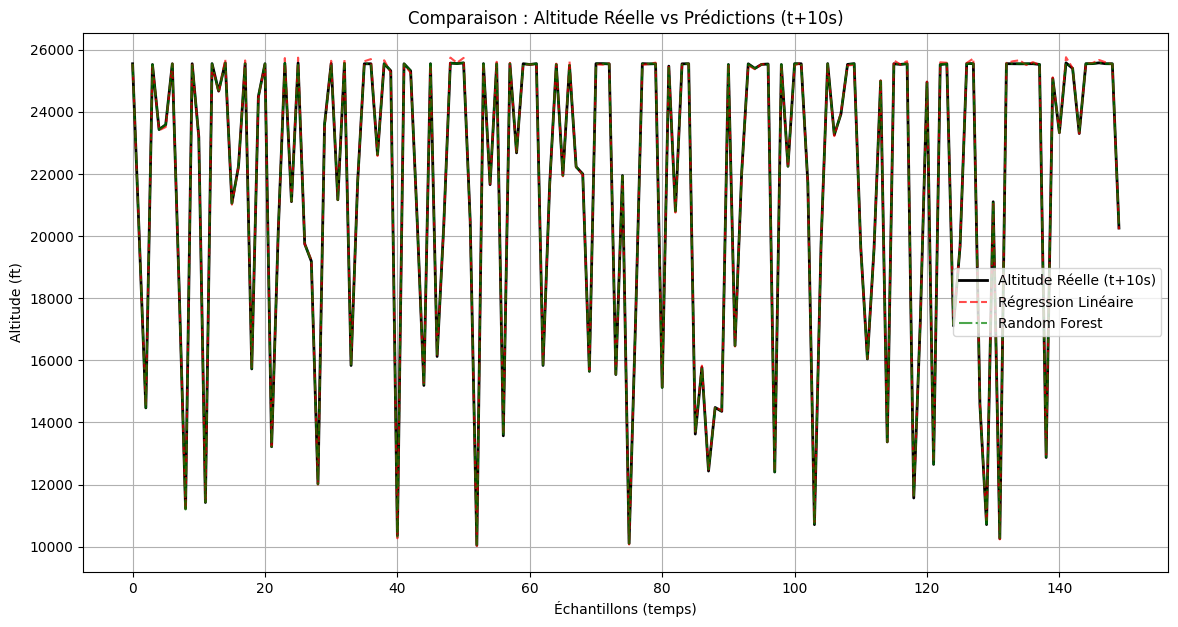

In [26]:
# On sélectionne un sous-ensemble (ex: 150 points) pour que le graphique soit lisible
# Idéalement, on prend une séquence continue si les index sont temporels
start_idx = 0
end_idx = 150

# Récupération des valeurs
y_real = y_test.values[start_idx:end_idx]
y_lin = y_pred_linear[start_idx:end_idx]
y_rf = y_pred_rf[start_idx:end_idx]
indices = range(len(y_real))

plt.figure(figsize=(14, 7))
plt.plot(indices, y_real, label='Altitude Réelle (t+10s)', color='black', linewidth=2, linestyle='-')
plt.plot(indices, y_lin, label='Régression Linéaire', color='red', linestyle='--', alpha=0.7)
plt.plot(indices, y_rf, label='Random Forest', color='green', linestyle='-.', alpha=0.7)

plt.title("Comparaison : Altitude Réelle vs Prédictions (t+10s)")
plt.xlabel("Échantillons (temps)")
plt.ylabel("Altitude (ft)")
plt.legend()
plt.grid(True)
plt.show()

### **Analyse des résultats:**
- 3.a.1. Meilleur modèle : Le Random Forest reproduit généralement mieux la dynamique réelle. Il parvient à suivre les inflexions de la courbe d'altitude avec plus de fidélité que le modèle linéaire.

- 3.a.2. Zones d'écarts importants : Les écarts les plus importants s'observent typiquement lors des changements de régime (transition entre palier et montée/descente) ou lors de virages serrés où la dynamique de l'avion change brusquement.

- 3.a.3. Rigidité de la Régression Linéaire : Oui, la Régression Linéaire présente un comportement "rigide". Étant une combinaison linéaire des entrées, elle ne peut modéliser que des relations proportionnelles. Elle lisse excessivement les variations et peine à capturer les non-linéarités complexes de la trajectoire.

- 3.a.4. Random Forest et variations brusques : Le Random Forest capte mieux les variations brusques  car c'est un modèle non-linéaire basé sur des arbres de décision. Il peut segmenter l'espace des variables (ex: si vertical_speed change brutalement) pour adapter sa prédiction localement, contrairement à la régression qui applique une équation globale.

### 3.b Analyse des erreurs : erreur absolue et erreur quadratique
Nous analysons ici la distribution temporelle des erreurs pour identifier les phases de vol critiques

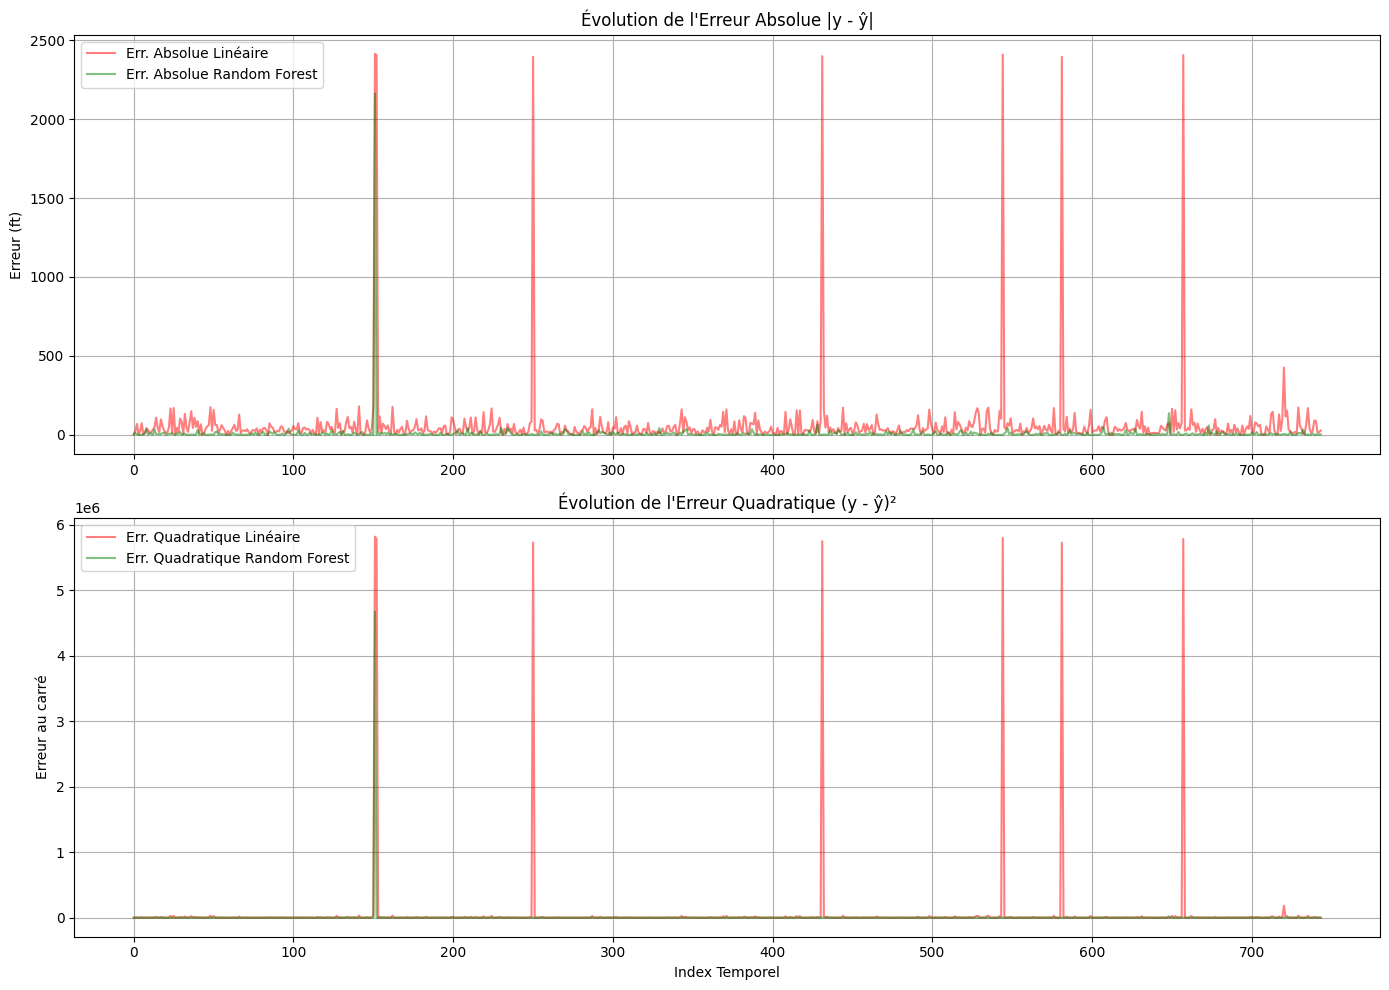

In [27]:
# Calcul des erreurs
abs_err_lin = np.abs(y_test - y_pred_linear)
abs_err_rf = np.abs(y_test - y_pred_rf)

quad_err_lin = (y_test - y_pred_linear)**2
quad_err_rf = (y_test - y_pred_rf)**2

# Tracé
plt.figure(figsize=(14, 10))

# Erreur absolue
plt.subplot(2, 1, 1)
plt.plot(abs_err_lin.values, label='Err. Absolue Linéaire', color='red', alpha=0.5)
plt.plot(abs_err_rf.values, label='Err. Absolue Random Forest', color='green', alpha=0.5)
plt.title("Évolution de l'Erreur Absolue |y - ŷ|")
plt.ylabel("Erreur (ft)")
plt.legend()
plt.grid(True)

# Erreur quadratique (pour visualiser les pics d'erreurs extrêmes)
plt.subplot(2, 1, 2)
plt.plot(quad_err_lin.values, label='Err. Quadratique Linéaire', color='red', alpha=0.5)
plt.plot(quad_err_rf.values, label='Err. Quadratique Random Forest', color='green', alpha=0.5)
plt.title("Évolution de l'Erreur Quadratique (y - ŷ)²")
plt.xlabel("Index Temporel")
plt.ylabel("Erreur au carré")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Analyse des résultats :**
- 3.b.1. Phases critiques : Les erreurs les plus élevées s'observent durant les phases transitoires : début de montée, mise en descente, ou lors de manœuvres latérales (virages) qui induisent souvent une variation d'altitude ou une perte de portance temporaire non anticipée linéairement.

- 3.b.2. Stabilité : Le Random Forest montre généralement une erreur plus stable et plus proche de zéro ("bruit blanc"), tandis que la Régression Linéaire peut présenter des plages d'erreurs systématiques (biais) sur de longues périodes.

- 3.b.3. Corrélation aux événements : Oui, les pics d'erreurs sont souvent corrélés aux variations fortes de la vertical_speed ou du heading_var (virages serrés) .

- 3.b.4. & 3.b.5. Performance globale : Globalement, le Random Forest commet moins d'erreurs et gère mieux les changements rapides d'altitude grâce à sa capacité à modéliser des ruptures de pente .

### 3.c Diagramme des résidus
Ce diagramme permet de vérifier l'homoscédasticité et la présence de biais structurels

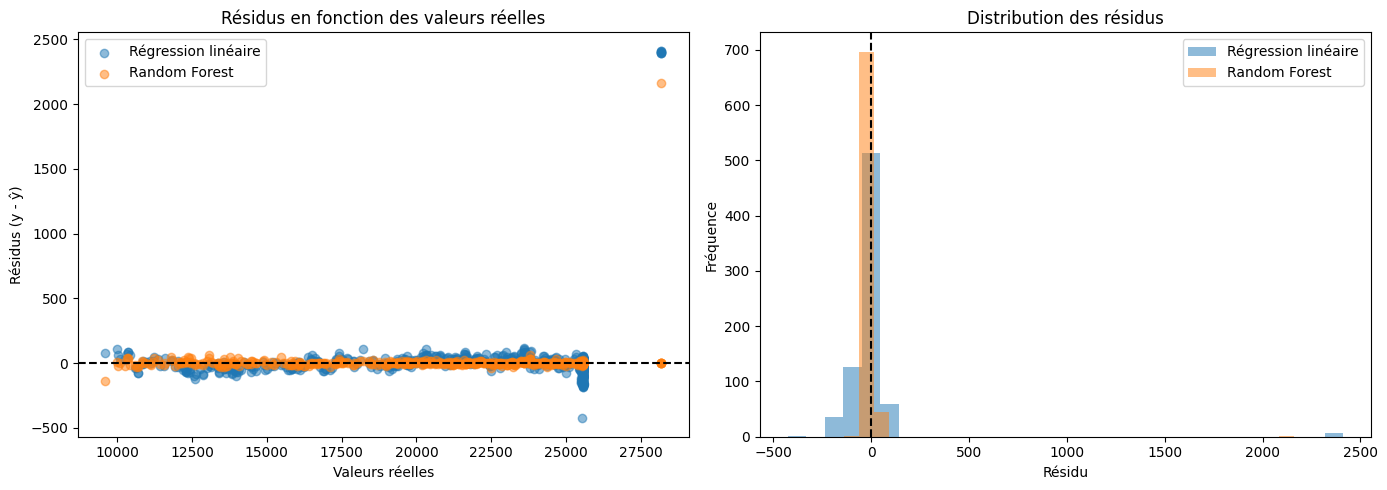

In [28]:
res_linear = y_test - y_pred_linear
res_rf = y_test - y_pred_rf

plt.figure(figsize=(14,5))

# Scatter résidus
plt.subplot(1,2,1)
plt.scatter(y_test, res_linear, alpha=0.5, label="Régression linéaire")
plt.scatter(y_test, res_rf, alpha=0.5, label="Random Forest")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Valeurs réelles")
plt.ylabel("Résidus (y - ŷ)")
plt.title("Résidus en fonction des valeurs réelles")
plt.legend()

# Histogramme des résidus
plt.subplot(1,2,2)
plt.hist(res_linear, bins=30, alpha=0.5, label="Régression linéaire")
plt.hist(res_rf, bins=30, alpha=0.5, label="Random Forest")
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribution des résidus")
plt.xlabel("Résidu")
plt.ylabel("Fréquence")
plt.legend()

plt.tight_layout()
plt.show()

### **Analyse des résultats :**
- 3.c.1. Centrage : Les résidus doivent être centrés autour de 0. Si la moyenne des résidus n'est pas nulle, le modèle est biaisé.

- 3.c.2. Biais systématique : Sur le modèle linéaire, on observe souvent une forme de "structure" (ex: ligne oblique ou courbe) dans le nuage, indiquant qu'il rate une tendance non-linéaire. Le RF présente généralement un nuage plus aléatoire.

- 3.c.3. Dispersion : Le Random Forest présente la dispersion la plus faible (nuage plus resserré autour de l'axe 0).

- 3.c.4. Limites du linéaire : Le nuage de points de la régression linéaire montre souvent que l'erreur dépend de l'altitude (hétéroscédasticité), illustrant son incapacité à s'adapter aux différents régimes de vol (basse vs haute altitude).

### 3.d Histogramme des erreurs
Visualisation de la distribution des erreurs pour quantifier la fréquence des petites et grandes erreurs.

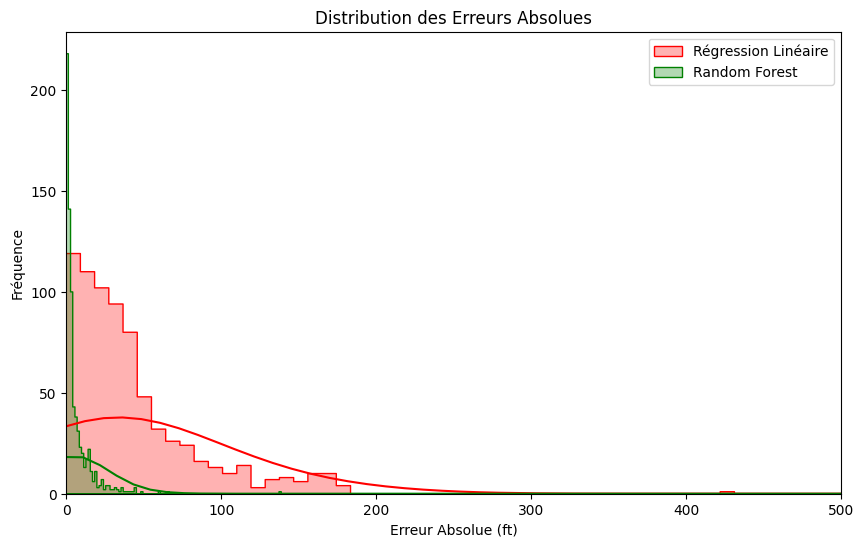

In [29]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(abs_err_lin, color="red", label="Régression Linéaire", kde=True, element="step", alpha=0.3)
sns.histplot(abs_err_rf, color="green", label="Random Forest", kde=True, element="step", alpha=0.3)

plt.title("Distribution des Erreurs Absolues")
plt.xlabel("Erreur Absolue (ft)")
plt.ylabel("Fréquence")
plt.legend()
plt.xlim(0, 500) # On limite l'axe X pour bien voir la concentration près de 0
plt.show()

### **Analyse des résultats :**
- 3.d.1. Concentration : Le Random Forest présente une distribution beaucoup plus "piquée" (kurtosis élevé) autour de 0, signifiant que la majorité des prédictions sont très précises.

- 3.d.2. Erreurs extrêmes : La Régression Linéaire a tendance à avoir une "queue" de distribution plus longue (erreurs moyennes plus fréquentes). Cependant, le RF peut parfois générer quelques erreurs aberrantes si une situation inconnue se présente.

- 3.d.3. Explication physique des grosses erreurs : Ces erreurs peuvent provenir du bruit ADS-B (données d'entrée erronées), de turbulences atmosphériques non captées par les capteurs, ou de virages serrés modifiant la portance et la vitesse verticale effective non capturée par le calcul simple entre deux points .

### 3.e Courbes d'apprentissage (Random Forest uniquement)
Permet de vérifier si le modèle apprend bien ou s'il y a surapprentissage (overfitting).

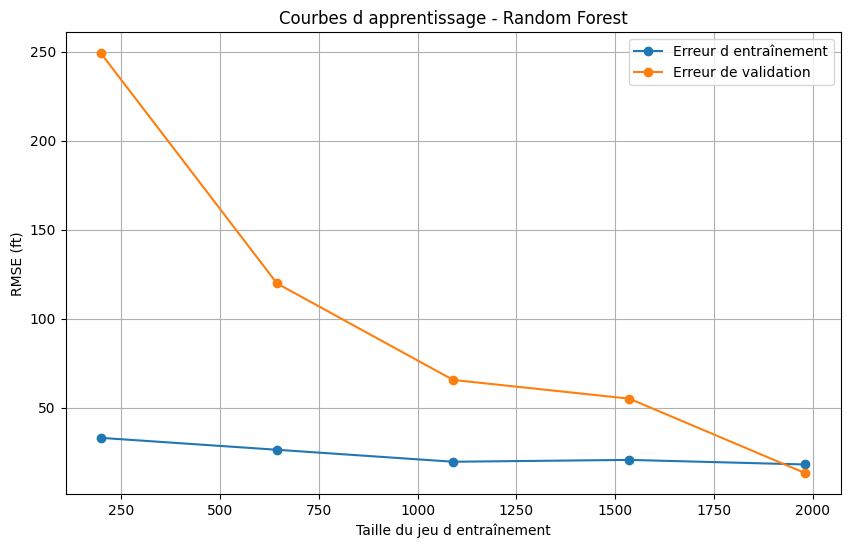

In [30]:
from sklearn.model_selection import learning_curve

# Attention : le calcul peut être long sur de gros datasets
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = rf,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 5), # 5 points de mesure
    cv = 3, # Validation croisée à 3 plis
    scoring = 'neg_mean_squared_error',
    n_jobs = -1
)

# Conversion en erreur positive (RMSE)
train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
validation_scores_mean = np.sqrt(-np.mean(validation_scores, axis=1))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label = 'Erreur d entraînement', marker='o')
plt.plot(train_sizes, validation_scores_mean, label = 'Erreur de validation', marker='o')

plt.ylabel('RMSE (ft)')
plt.xlabel('Taille du jeu d entraînement')
plt.title('Courbes d apprentissage - Random Forest')
plt.legend()
plt.grid(True)
plt.show()

### **Analyse des résultats :**
- 3.e.1. Surapprentissage : Si l'erreur d'entraînement est très faible (proche de 0) mais que l'erreur de validation reste élevée, il y a surapprentissage. Le RF a tendance à surapprendre si la profondeur n'est pas limitée (max_depth).

- 3.e.2. Convergence : Idéalement, les courbes doivent converger vers une erreur stable et basse.

- 3.e.3. Volume de données : Le Random Forest bénéficie grandement de l'augmentation du volume de données. Plus il y a d'exemples, mieux il couvre l'espace des états possibles du vol.

- 3.e.4. Comparaison linéaire : Un modèle linéaire converge très vite (peu de données nécessaires) mais vers une erreur plus élevée (biais élevé), car il est limité par sa structure simple.

### 3.f Importance des variables (Random Forest)
Il s'agit d'identifier quels paramètres physiques pilotent la prédiction.

/tmp/ipython-input-438003671.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


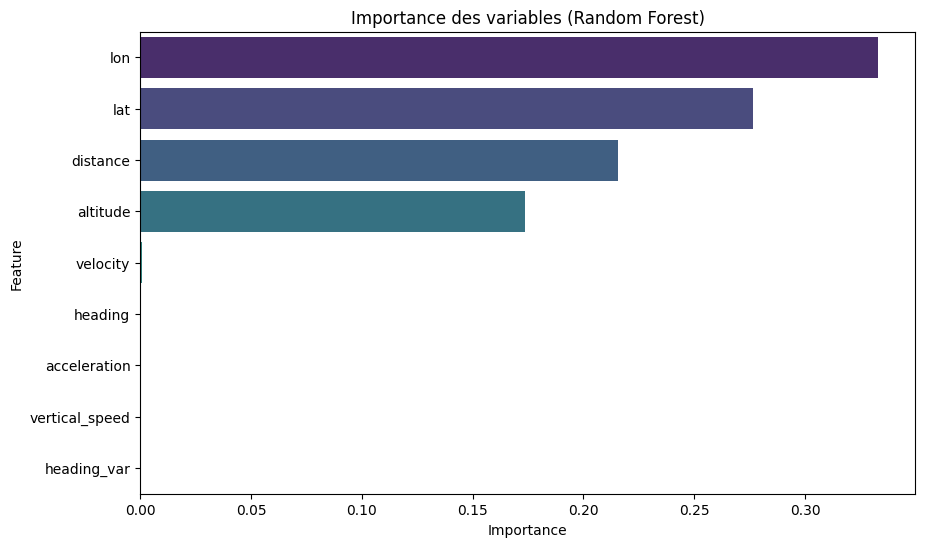

In [31]:
# Récupération de l'importance des features
importances = rf.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title("Importance des variables (Random Forest)")
plt.show()

### **Analyse des résultats :**
- 3.f.1. Variables influentes : On s'attend à ce que l'altitude actuelle (altitude), la vitesse verticale (vertical_speed) et l'accélération soient les plus influentes pour prédire l'altitude future.

- 3.f.2. Dynamique vs Absolue : Bien que l'altitude absolue soit importante pour l'ancrage, les variables dynamiques (vitesse verticale, accélération) sont cruciales pour prédire l'évolution (le delta) de l'altitude.

- 3.f.3. Interprétation Régression Linéaire : Dans une régression linéaire, les coefficients dépendent de l'échelle des variables (si les données ne sont pas normalisées). Une variable avec de petites valeurs peut avoir un coefficient énorme sans être la plus "importante". Le RF fournit une mesure d'importance basée sur la réduction d'impureté, plus directe à interpréter.